In [1]:
# Import required libraries and dependencies
import pandas as pd
import hvplot.pandas
import requests
import json
from config import api_key
from pprint import pprint
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
#Multiple time period func
def fetch_data(time_period):
    url = "https://coinranking1.p.rapidapi.com/coins"

    querystring = {"referenceCurrencyUuid":"yhjMzLPhuIDl","timePeriod": time_period,
                   "tiers[0]":"1","orderBy":"marketCap","orderDirection":"desc",
                   "limit":"50","offset":"0"}

    headers = {
        "X-RapidAPI-Key": f"{api_key}",
        "X-RapidAPI-Host": "coinranking1.p.rapidapi.com"
    }
    #API call
    response = requests.get(url, headers=headers, params=querystring)
    #Error formatting
    if response.status_code == 200:
        return pd.DataFrame(response.json()['data']['coins']) 
    else:
        return pd.DataFrame()
    
df_24hr = fetch_data('24h').drop(columns=['iconUrl', 'coinrankingUrl'])
df_7d = fetch_data('7d').drop(columns=['iconUrl', 'coinrankingUrl'])
df_30d = fetch_data('30d').drop(columns=['iconUrl', 'coinrankingUrl'])
df_3m = fetch_data('3m').drop(columns=['iconUrl', 'coinrankingUrl'])
df_1y = fetch_data('1y').drop(columns=['iconUrl', 'coinrankingUrl'])
df_3y = fetch_data('3y').drop(columns=['iconUrl', 'coinrankingUrl'])
df_5y = fetch_data('5y').drop(columns=['iconUrl', 'coinrankingUrl'])

In [3]:
columns_to_drop = ['color', 'listedAt', 'tier', 'lowVolume']

df_24hr_cleaned = df_24hr.drop(columns = columns_to_drop)
df_7d_cleaned = df_7d.drop(columns = columns_to_drop)
df_30d_cleaned = df_30d.drop(columns = columns_to_drop)
df_3m_cleaned = df_3m.drop(columns = columns_to_drop)
df_1y_cleaned = df_1y.drop(columns = columns_to_drop)
df_3y_cleaned = df_3y.drop(columns = columns_to_drop)
df_5y_cleaned = df_5y.drop(columns = columns_to_drop)

In [4]:
# Convert sparkline from obj to float
df_24hr_cleaned['sparkline'] = df_24hr_cleaned['sparkline'].apply(lambda x: [float(i) for i in x])
df_7d_cleaned['sparkline'] = df_7d_cleaned['sparkline'].apply(lambda x: [float(i) for i in x])
df_30d_cleaned['sparkline'] = df_30d_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_3m_cleaned['sparkline'] = df_3m_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_1y_cleaned['sparkline'] = df_1y_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_3y_cleaned['sparkline'] = df_3y_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])
df_5y_cleaned['sparkline'] = df_5y_cleaned['sparkline'].apply(lambda x: [float(i) if i is not None else 0.0 for i in x])

# Function to calculate rolling mean
def calculate_latest_rolling_mean(lst, window=5):
#     lst = [float(x) for x in lst]
    if len(lst) < window:
        return 
    else:
        return np.mean(lst[-window:])
               
df_24hr_cleaned['latest_moving_avg'] = df_24hr_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_7d_cleaned['latest_moving_avg'] = df_7d_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_30d_cleaned['latest_moving_avg'] = df_30d_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_3m_cleaned['latest_moving_avg'] = df_3m_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_1y_cleaned['latest_moving_avg'] = df_1y_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_3y_cleaned['latest_moving_avg'] = df_3y_cleaned['sparkline'].apply(calculate_latest_rolling_mean)
df_5y_cleaned['latest_moving_avg'] = df_5y_cleaned['sparkline'].apply(calculate_latest_rolling_mean)

In [6]:
features = df_24hr_cleaned[['marketCap', 'price', 'change',  '24hVolume', 'latest_moving_avg']]

In [7]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

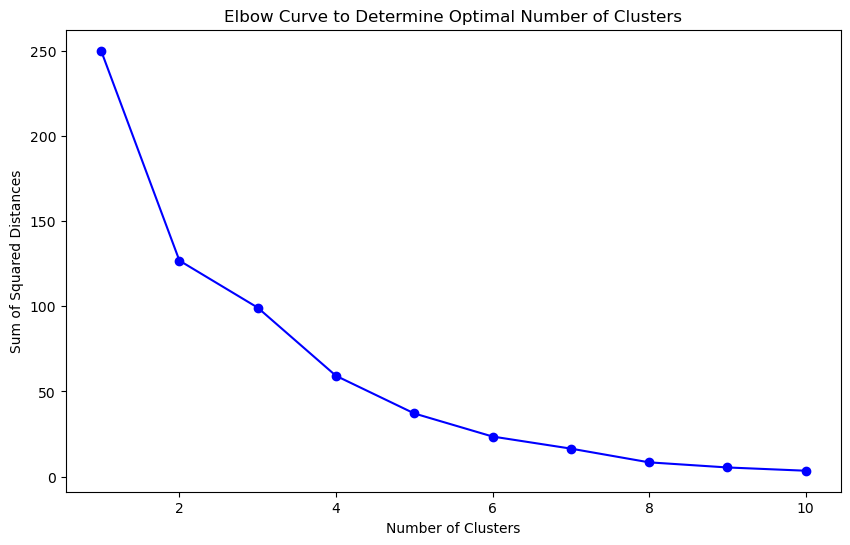

In [8]:
#Elbow Curve
# Determine range for k (e.g., 1 to 10 clusters)
range_n_clusters = list(range(1,11))
sum_of_squared_distances = []

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n)
    kmeans = kmeans.fit(scaled_features)
    
    # Append the inertia (SSD) to the list
    sum_of_squared_distances.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10,6))
plt.plot(range_n_clusters, sum_of_squared_distances, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Curve to Determine Optimal Number of Clusters')
plt.show()

In [9]:
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(scaled_features)

C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\josea\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [10]:
df_24hr_cleaned['cluster'] = clusters
df_24hr_clustered = df_24hr_cleaned.copy()

In [11]:
df_24hr_clustered

,uuid,symbol,name,marketCap,price,change,rank,sparkline,24hVolume,btcPrice,latest_moving_avg,cluster
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-2.45,1,"[25893.29121967129, 25864.201484576737, 25866....",13675687112,1,2.525221e+04,1
1,razxDUgYGNAdQ,ETH,Ethereum,190679381199,1562.2341516935528,-3.68,2,"[1620.2661407310688, 1619.32367150981, 1620.03...",11282128538,0.06178818232640264,1.553259e+03,0
2,HIVsRcGKkPFtW,USDT,Tether USD,83375182163,1.0042057788039032,-0.23,3,"[1.0069291180994684, 1.005950285965494, 1.0047...",23780352731,0.000039717509495423,1.004351e+00,0
3,WcwrkfNI4FUAe,BNB,BNB,31603499650,206.64773851824307,-3.14,4,"[213.29680654627808, 213.01465884576766, 212.8...",429593441,0.008173159017847808,2.067672e+02,0
4,aKzUVe4Hh_CON,USDC,USDC,26190954553,1.0044857451509634,-0.24,5,"[1.0072603322842257, 1.0062347740611413, 1.004...",5589733522,0.000039728582490901,1.004664e+00,0
5,-l8Mn2pVlRs-p,XRP,XRP,25327887892,0.4771370438626586,-4.43,6,"[0.49878048541390513, 0.4987511985672383, 0.49...",1264603885,0.000018871326445467,4.773323e-01,0
6,a91GCGd_u96cF,DOGE,Dogecoin,8571149578,0.06122829776382711,-0.58,7,"[0.06149363572064739, 0.06155960138166726, 0.0...",252164511,0.000002421650571181,6.083102e-02,0
7,qzawljRxB5bYu,ADA,Cardano,8530083947,0.24340359187263247,-2.27,8,"[0.24908608396491747, 0.24940805025318585, 0.2...",139398708,0.000009626895876795,2.422409e-01,0
8,zNZHO_Sjf,SOL,Solana,7354423667,17.898050611651076,-1.88,9,"[18.259668878232933, 18.379693976291776, 18.46...",442071769,0.000707888771527003,1.774526e+01,0
9,qUhEFk1I61atv,TRX,TRON,7000864245,0.07826387988779324,-0.90,10,"[0.0789329105947706, 0.07889627783142282, 0.07...",211394662,0.000003095427708347,7.801060e-02,0


In [12]:
# Plot your data to see what's in your DataFrame
df_24hr_clustered.hvplot.line(
    width=800,
    height=400,
    rot=90
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [14]:
merged_data = df_24hr_clustered.merge(df_1y_cleaned, on='symbol', suffixes=('_24hr', '_1y'))
merged_data.head()

,uuid_24hr,symbol,name_24hr,marketCap_24hr,price_24hr,change_24hr,rank_24hr,sparkline_24hr,24hVolume_24hr,btcPrice_24hr,...,uuid_1y,name_1y,marketCap_1y,price_1y,change_1y,rank_1y,sparkline_1y,24hVolume_1y,btcPrice_1y,latest_moving_avg_1y
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-2.45,1,"[25893.29121967129, 25864.201484576737, 25866....",13675687112,1,...,Qwsogvtv82FCd,Bitcoin,492600192381,25283.704632074867,16.14,1,"[19820.700505355522, 19631.646983618004, 17692...",13675687112,1,22876.655593
1,razxDUgYGNAdQ,ETH,Ethereum,190679381199,1562.2341516935528,-3.68,2,"[1620.2661407310688, 1619.32367150981, 1620.03...",11282128538,0.06178818232640264,...,razxDUgYGNAdQ,Ethereum,190679381199,1562.2341516935528,-11.30,2,"[1488.1610777547928, 1364.9769066327108, 1307....",11282128538,0.06178818232640264,1498.570821
2,HIVsRcGKkPFtW,USDT,Tether USD,83375182163,1.0042057788039032,-0.23,3,"[1.0069291180994684, 1.005950285965494, 1.0047...",23780352731,0.000039717509495423,...,HIVsRcGKkPFtW,Tether USD,83375182163,1.0042057788039032,0.68,3,"[1.0003281517181468, 1.0003818174423569, 1.000...",23780352731,0.000039717509495423,0.802438
3,WcwrkfNI4FUAe,BNB,BNB,31603499650,206.64773851824307,-3.14,4,"[213.29680654627808, 213.01465884576766, 212.8...",429593441,0.008173159017847808,...,WcwrkfNI4FUAe,BNB,31603499650,206.64773851824307,-29.87,4,"[278.16384177339125, 281.4639170880019, 299.17...",429593441,0.008173159017847808,227.765782
4,aKzUVe4Hh_CON,USDC,USDC,26190954553,1.0044857451509634,-0.24,5,"[1.0072603322842257, 1.0062347740611413, 1.004...",5589733522,0.000039728582490901,...,aKzUVe4Hh_CON,USDC,26190954553,1.0044857451509634,0.69,5,"[1.000295825280198, 1.0003581417782612, 1.0008...",5589733522,0.000039728582490901,0.802074


In [43]:
fast_window = 7
slow_window = 30

# Expand the lists in the sparkline column
df_expanded = df_30d_cleaned.explode('sparkline')

# Convert the sparkline column to float for calculations
df_expanded['sparkline'] = df_expanded['sparkline'].astype(float)


# Group by the coin identifier symbol and compute the rolling means
df_expanded['fast_SMA'] = df_expanded.groupby('symbol')['sparkline'].transform(lambda x: x.rolling(fast_window).mean())
df_expanded['slow_SMA'] = df_expanded.groupby('symbol')['sparkline'].transform(lambda x: x.rolling(slow_window).mean())


df_expanded.head(25)
# Compute the signals
# df_expanded['signal'] = np.where(df_expanded['fast_SMA'] > df_expanded['slow_SMA'], 'buy',
#                                 np.where(df_expanded['fast_SMA'] < df_expanded['slow_SMA'],'sell', 'hold'))

,uuid,symbol,name,marketCap,price,change,rank,sparkline,24hVolume,btcPrice,latest_moving_avg,fast_SMA,slow_SMA
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,29390.203435,13675687112,1,20769.08814,NaN,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,29370.345022,13675687112,1,20769.08814,NaN,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,29329.150908,13675687112,1,20769.08814,NaN,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,29187.028517,13675687112,1,20769.08814,NaN,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,28292.218642,13675687112,1,20769.08814,NaN,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,26450.890944,13675687112,1,20769.08814,NaN,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,26151.953543,13675687112,1,20769.08814,28310.255858,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,26357.176581,13675687112,1,20769.08814,27876.966308,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,26212.535101,13675687112,1,20769.08814,27425.850605,NaN
0,Qwsogvtv82FCd,BTC,Bitcoin,492600192381,25283.704632074867,-14.19,1,26063.664666,13675687112,1,20769.08814,26959.352570,NaN


In [41]:
# print(df_expanded[['symbol', 'sparkline']].head(70))
print(df_expanded['uuid'].value_counts())


Qwsogvtv82FCd    30
FEbS54wxo4oIl    30
Knsels4_Ol-Ny    30
ncYFcP709        30
jad286TjB        30
ymQub4fuB        30
aMNLwaUbY        30
Pe93bIOD2        30
DXwP4wF9ksbBO    30
qFakph2rpuMOL    30
JCKLgWPAF        30
QUC5kVAxSoB-     30
Z96jIvLU7        30
razxDUgYGNAdQ    30
1Uo6s62Oc        30
Hm3OlynlC        30
bauj_21eYVwso    30
3nNpuxHJ8        30
QJZRUGyNI        30
JY1_q2c0g        30
7C4Mh4xy1yDel    30
ixgUfzmLR        30
65PHZTpmE55b     30
BoI4ux0nd        30
hnfQfsYfeIGUQ    30
67YlI0K1b        30
vSo2fu9iE1s0Y    30
3mVx2FX_iJFp5    30
HIVsRcGKkPFtW    30
WcwrkfNI4FUAe    30
aKzUVe4Hh_CON    30
-l8Mn2pVlRs-p    30
a91GCGd_u96cF    30
qzawljRxB5bYu    30
zNZHO_Sjf        30
qUhEFk1I61atv    30
CiixT63n3        30
Mtfb0obXVh59u    30
25W7FG7om        30
uW2tk-ILY0ii     30
x4WXHge-vvFY     30
xz24e0BjL        30
D7B1x_ks7WhV5    30
MoTuySvg7        30
ZlZpzOJo43mIo    30
_H5FVG9iW        30
dvUj0CzDZ        30
VLqpJwogdhHNb    30
f3iaFeCKEmkaZ    30
z2PZIKQL7        30


# Labeling Analysis

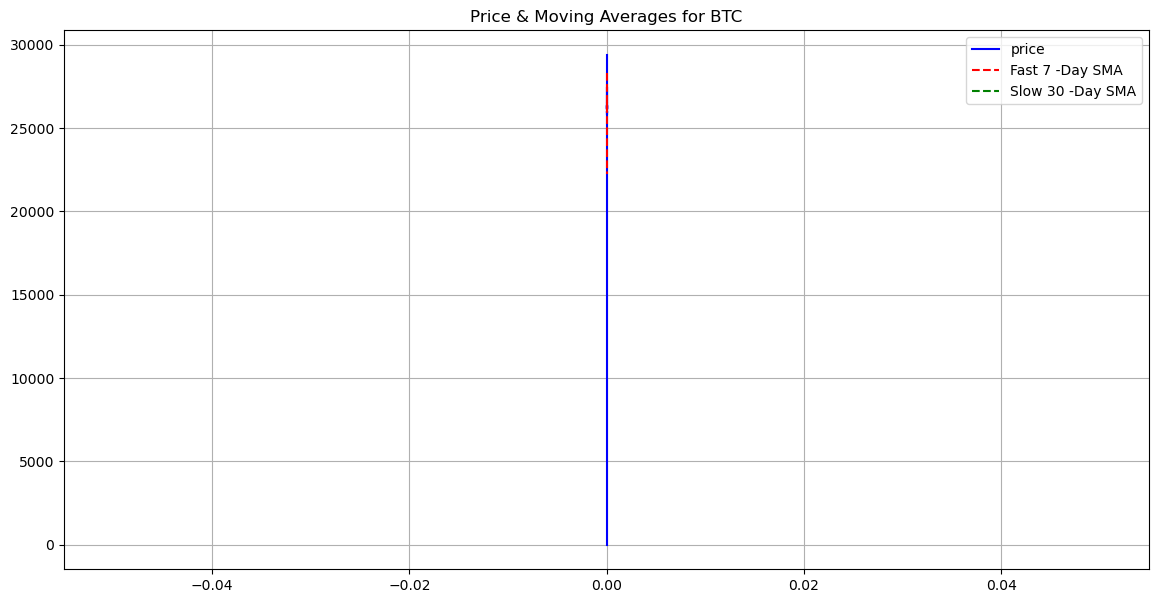

In [36]:
coin = 'BTC'
coin_data = df_expanded[df_expanded['symbol']== coin] #Replace BTC with any coin symbol

plt.figure(figsize=(14,7))
plt.plot(coin_data['sparkline'], label = 'price', color='blue')
plt.plot(coin_data['fast_SMA'], label = f'Fast {fast_window} -Day SMA', color='red', linestyle='--')
plt.plot(coin_data['slow_SMA'], label = f'Slow {slow_window} -Day SMA', color='green', linestyle='--')
plt.title(f'Price & Moving Averages for {coin}')
plt.legend()
plt.grid(True)
plt.show()

---

### Prepare the Data

In [ ]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
df_market_data_scaled = StandardScaler().fit_transform(df_market_data[['price_change_percentage_24h', 'price_change_percentage_7d', 'price_change_percentage_14d',
                                                                       'price_change_percentage_30d', 'price_change_percentage_60d', 'price_change_percentage_200d',
                                                                       'price_change_percentage_1y']])


In [ ]:
# Create a DataFrame with the scaled data
df_market_data_transformed = pd.DataFrame(df_market_data_scaled, columns=['price_change_percentage_24h', 'price_change_percentage_7d', 'price_change_percentage_14d',
                                                                           'price_change_percentage_30d', 'price_change_percentage_60d', 'price_change_percentage_200d',
                                                                           'price_change_percentage_1y'])

# Copy the crypto names from the original data
df_market_data_transformed['coin_id'] = df_market_data.index
# Set the coinid column as index
df_market_data_transformed = df_market_data_transformed.set_index('coin_id')

# Display sample data
df_market_data_transformed.head()

---

### Find the Best Value for k Using the Original Data.

In [ ]:
# Create an empty list to store the inertia values
inertia = []
# Create a list with the number of k-values from 1 to 11
k = list(range(1,11))

In [ ]:
# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model= KMeans(n_clusters= i, random_state= 1)
    k_model.fit(df_market_data_scaled)
    inertia.append(k_model.inertia_)

In [ ]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {'k': k, 'inertia': inertia}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

df_elbow.head()

In [ ]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_plot = df_elbow.hvplot.line(
    x= 'k',
    y= 'inertia',
    title= 'Elbow Curve',
    xticks = k
)

elbow_plot

#### Answer the following question: 

**Question:** What is the best value for `k`?

**Answer:**  The best value is 4. This is where the line will soon start to flatten out.

---

### Cluster Cryptocurrencies with K-means Using the Original Data

In [ ]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters = 4, random_state= 1)

In [ ]:
# Fit & Predict the K-Means model using the scaled data
predicted_clusters = model.fit_predict(df_market_data_transformed)

In [ ]:
# Create a copy of the DataFrame
df_market_data_predicted = df_market_data_transformed.copy()

In [ ]:
# Add a new column to the DataFrame with the predicted clusters
df_market_data_predicted['coin_clusters'] = predicted_clusters

# Display sample data
df_market_data_predicted.head()

In [ ]:
# Create a scatter plot using hvPlot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.
clusters_plot = df_market_data_predicted.hvplot.scatter(
    x="price_change_percentage_24h",
    y="price_change_percentage_7d",
    by="coin_clusters",
    hover_cols= 'index',
    title= "Crypto Clusters"
)
clusters_plot

---

### Optimize Clusters with Principal Component Analysis.

In [ ]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

In [ ]:
# Use the PCA model with `fit_transform` to reduce to 
# three principal components.
mrkt_data_pca = pca.fit_transform(df_market_data)
# View the first five rows of the DataFrame. 
mrkt_data_pca[:5]

In [ ]:
# Retrieve the explained variance to determine how much information 
# can be attributed to each principal component.
pca.explained_variance_ratio_

In [ ]:
sum(pca.explained_variance_ratio_)

#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** 99.9%

In [ ]:
# Create a new DataFrame with the PCA data.
mrkt_data_pca = pd.DataFrame(mrkt_data_pca, columns=["PCA1", "PCA2", "PCA3"])


# Copy the crypto names from the original data
mrkt_data_pca['coin_id'] = df_market_data.index
# Set the coinid column as index
mrkt_data_pca = mrkt_data_pca.set_index('coin_id')


# Display sample data
mrkt_data_pca.head()

---

### Find the Best Value for k Using the PCA Data

In [ ]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1,11))

In [ ]:
# Create an empy list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_pca`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters= i, random_state=0)
    k_model.fit(mrkt_data_pca)
    inertia.append(k_model.inertia_)

In [ ]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {'k': k, 'inertia': inertia}
# Create a DataFrame with the data to plot the Elbow curve
df_mrkt_elbow = pd.DataFrame(elbow_data)

df_mrkt_elbow

In [ ]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_pca_plot = df_mrkt_elbow.hvplot.line(
    x='k',
    y='inertia',
    title='Elbow Curve'
)
elbow_pca_plot

#### Answer the following questions: 

* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:**2


* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** Yes by two clusters
 

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [ ]:
# Initialize the K-Means model using the best value for k
k_pca = KMeans(n_clusters=2)

In [ ]:
# Fit the K-Means model using the PCA data
k_pca = model.fit_predict(mrkt_data_pca)

In [ ]:
# Print the resulting array of cluster values.
k_pca

In [ ]:
# Create a copy of the DataFrame with the PCA data
mrkt_data_pca_prediction = mrkt_data_pca.copy()

# Add a new column to the DataFrame with the predicted clusters
mrkt_data_pca_prediction['coin_clusters'] = k_pca

# Display sample data
mrkt_data_pca_prediction.head()

In [ ]:
# Create a scatter plot using hvPlot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.
cluster_pca_plot = mrkt_data_pca_prediction.hvplot.scatter(
   x="PCA1",
   y="PCA2",
   hover_cols = "index",
   by= "coin_clusters",
   title= "Crypto Clusters" 
)

cluster_pca_plot

### Visualize and Compare the Results

In this section, you will visually analyze the cluster analysis results by contrasting the outcome with and without using the optimization techniques.

In [ ]:
# Composite plot to contrast the Elbow curves
elbow_plot  * elbow_pca_plot

In [ ]:
# Composite plot to contrast the clusters
clusters_plot + cluster_pca_plot

#### Answer the following question: 

  * **Question:** After visually analyzing the cluster analysis results, what is the impact of using fewer features to cluster the data using K-Means?

  * **Answer:** The data differs greatly when using the smaller cluster size.